In [309]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [310]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # for making prettier plots!

In [311]:
data = pd.read_csv("../housing_data/opa_properties_public.csv", low_memory=False)

In [312]:
data.shape

(582933, 82)

In [313]:
data.columns

Index(['the_geom', 'the_geom_webmercator', 'assessment_date', 'basements',
       'beginning_point', 'book_and_page', 'building_code',
       'building_code_description', 'category_code',
       'category_code_description', 'census_tract', 'central_air',
       'cross_reference', 'date_exterior_condition', 'depth',
       'exempt_building', 'exempt_land', 'exterior_condition', 'fireplaces',
       'frontage', 'fuel', 'garage_spaces', 'garage_type',
       'general_construction', 'geographic_ward', 'homestead_exemption',
       'house_extension', 'house_number', 'interior_condition', 'location',
       'mailing_address_1', 'mailing_address_2', 'mailing_care_of',
       'mailing_city_state', 'mailing_street', 'mailing_zip', 'market_value',
       'market_value_date', 'number_of_bathrooms', 'number_of_bedrooms',
       'number_of_rooms', 'number_stories', 'off_street_open',
       'other_building', 'owner_1', 'owner_2', 'parcel_number', 'parcel_shape',
       'quality_grade', 'recording_d

In [314]:
# The following columns were deemed to not impact the model based on the data they provide. Many of the columns were missing data and most of the categorical columns have no correlations
drop_column_list = ['the_geom', 'assessment_date','beginning_point', 'book_and_page', 'category_code_description', 'cross_reference', 'house_number','location', 'mailing_address_1', 'mailing_address_2', 
                    'mailing_care_of', 'mailing_city_state', 'mailing_street', 'market_value_date','the_geom_webmercator','other_building','owner_1', 'owner_2', 'parcel_number', 'recording_date', 
                    'sale_date', 'registry_number', 'sale_price', 'unit', 'objectid','building_code', 'census_tract', 'date_exterior_condition', 'year_built_estimate', 'house_extension', 'mailing_zip', 
                    'sewer', 'site_type','state_code', 'street_designation', 'street_name', 'street_direction', 'geographic_ward']

data = data.drop(drop_column_list, axis = 1)

In [315]:
# Drop empty rows
data = data.dropna(subset=["market_value"])

In [316]:
# Check if there are still null rows
data.market_value.isnull().any()

False

In [360]:
data.shape

(582710, 44)

In [317]:
# Drop rows that have a market value of 0
data = data.drop(data[data.market_value == 0].index)

Text(0.5, 0, 'Number of Missing values')

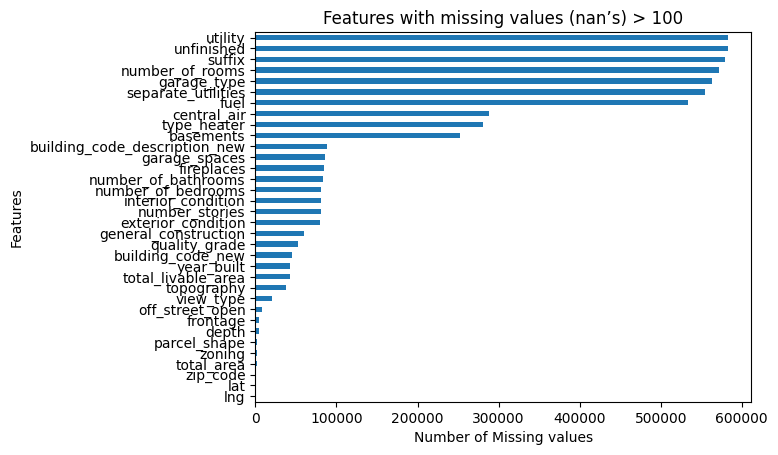

In [318]:
# Visualize missing values in columns
missing = data.isnull().sum()
missing = missing[missing >= 100]
missing.sort_values(inplace=True)
missing.plot.barh()
plt.title("Features with missing values (nan’s) > 100")
plt.ylabel("Features")
plt.xlabel("Number of Missing values")

In [319]:
# This takes a while but was necessary when doing replacements

# Remove spaces from each row
def remove_spaces(row):
    return row.str.strip()

data = data.apply(remove_spaces, axis=1)

### Category Code

In [320]:
# Code value: 1 = Single Family
# Code value: 2 = Multi Family
# Code value: 3 = Mixed Use
# Code value: 4 = Commercial
# Code value: 5 = Industrial
# Code value: 6 = Vacant Land

data.category_code.value_counts(dropna=False)

NaN    582710
Name: category_code, dtype: int64

In [321]:
# Create a mask to drop rows
values_to_drop = [num for num in range(4, 17)]
mask_category_code = data["category_code"].isin(values_to_drop)
data = data.loc[~mask_category_code]

In [322]:
# Code value: 1 = Single Family
# Code value: 2 = Multi Family
# Code value: 3 = Mixed Use
data.category_code.value_counts(dropna=False)

NaN    582710
Name: category_code, dtype: int64

In [323]:
data.shape

(582710, 44)

### Depth

In [324]:
# Delete rows that have a depth of 0
data = data.drop(data[data.depth == 0].index)

### Longitude

In [325]:
# Replace empty longitude values with the mean
data["lng"] = data.lng.fillna(data.lng.mean())

In [326]:
# Convert the longitude values to be positive for machine learning purposes
data.loc[:, "lng"] = data['lng'].abs()

### Latitude


In [327]:
# Replace empty latitude values with the mean
data["lat"] = data.lat.fillna(data.lat.mean())

In [328]:
# Convert the latitude values to be positive for machine learning purposes
data.loc[:, "lat"] = data['lat'].abs()

In [359]:
data.shape

(582710, 44)

### Basements

In [330]:
# [NOTE: REPLACING 'NaN' WITH 'K'] 
# 0 = No Basement [NOTE: REPLACING '0' WITH 'L']
# D = Full – Unknown Finish
# F = Partial - Semi-Finished 
# H = Partial - Unknown Finish
# C = Full - Unfinished
# A = Full - Finished 
# J = Unknown Size - Unfinished
# E = Partial - Finished 
# I = Unknown Size - Finished 
# G = Partial - Unfinished
# B = Full - Semi-Finished

# 1 = ? Replace with M
# 2 = ? Replace with N
# 3 = ? Replace with O
# 4 = ? Replace with P

In [331]:
data.basements.value_counts(dropna=False)

NaN    252098
D      107983
F       64175
H       57408
C       34011
A       28161
0       10864
E       10080
J        7584
G        4357
B        3134
I        2058
1         671
4          98
2          20
3           8
Name: basements, dtype: int64

In [332]:
data.loc[:, "basements"] = data.loc[:, "basements"].fillna('K')
data.loc[:, "basements"] = data['basements'].replace('0', 'L').replace('1', 'M').replace('2', 'N').replace('3', 'O').replace('4', 'P')

### Central Air

In [333]:
data.central_air.value_counts(dropna=False)

NaN    288566
N      164533
Y      128341
0        1122
1         148
Name: central_air, dtype: int64

In [334]:
# Replacing '0' with 'N' (i.e. NO Central Air)
data.loc[:, "central_air"] = data['central_air'].replace('0', 'N')
# Replacing the "NaNs" with 'N'
data.loc[:, "central_air"] = data['central_air'].fillna('N')
# Replacing '1' with 'Y' (i.e. Central Air)
data.loc[:, "central_air"] = data['central_air'].replace('1', 'N')

### Exterior Condition

In [335]:
# 4.0 Average
# 3.0 Above Average
# 5.0 Below Average
# 2.0 Newer Construction / Rehabbed
# 7.0 Sealed / Structurally Compromised
# 6.0 Vacant
# 0.0 Not Applicable

In [336]:
data.exterior_condition.value_counts(dropna=False)

NaN    582710
Name: exterior_condition, dtype: int64

In [337]:
# Fill in nan with not applicable (0.0)
data.loc[:, "exterior_condition"] = data.loc[:, "exterior_condition"].fillna(0.0)

### Fuel Heating

In [338]:
# A = Natural Gas
# C = Electric
# B = Oil heat
# E = Solar
# G = Other 
# H = None

In [339]:
data.fuel.value_counts(dropna=False)

NaN    533473
A       46469
C        2206
B         469
G          56
E          16
H          14
I           6
D           1
Name: fuel, dtype: int64

In [358]:
# Replace Nan with other (G)
data.loc[:, "fuel"] = data.loc[:, "fuel"].fillna('G')

### Garage Type

In [357]:
data.garage_type.value_counts(dropna=False)

0.0    582710
Name: garage_type, dtype: int64

In [342]:
# Replace Nan with no garage (0.0)
data.loc[:, "garage_type"] = data.loc[:, "garage_type"].fillna(0.0)

### General Construction

In [343]:
# A = Common brick 
# B = Brick and Siding 
# E = Stone 
# C = Frame and siding 
# F = Stucco/Cement 
# G = Other/Mix 
# H = Brick and stucco 
# J = Stone/stucco 
# I = Stucco and siding 
# D = Frame and shingle 

In [344]:
data.head

<bound method NDFrame.head of        basements  building_code_description  category_code central_air  depth  \
0              K  VACANT LAND COMMER < ACRE            NaN           N    NaN   
1              K  VACANT LAND RESIDE < ACRE            NaN           N    NaN   
2              K  VACANT LAND RESIDE < ACRE            NaN           N    NaN   
3              K  VACANT LAND RESIDE < ACRE            NaN           N    NaN   
4              K  VACANT LAND RESIDE < ACRE            NaN           N    NaN   
...          ...                        ...            ...         ...    ...   
582928         A    ROW W/GAR 3 STY MASONRY            NaN           Y    NaN   
582929         K  VACANT LAND COMMER < ACRE            NaN           Y    NaN   
582930         K  VACANT LAND COMMER < ACRE            NaN           Y    NaN   
582931         A          ROW 4 STY MASONRY            NaN           Y    NaN   
582932         L    ROW W/GAR 4 STY MASONRY            NaN           Y    NaN  

In [345]:
data.general_construction.value_counts(dropna=False)

A      443259
NaN     59661
B       33918
E       11717
C       11467
F        8769
H        4913
G        3788
J        1731
3        1187
I        1158
1         292
D         270
4         171
9         160
5         133
6         115
8           1
Name: general_construction, dtype: int64

In [346]:
# Replace Nan with other (G)
data.loc[:, "general_construction"] = data.loc[:, "general_construction"].fillna("G")
# Replace number with numerical counter part (not sure if this is correct)
data.loc[:, "general_construction"] = data["general_construction"].replace("1", "A",).replace("3", "C").replace("4", "D").replace("5", "E").replace("6", "F").replace("8", "H").replace("9", "I")

### Parcel Shape

In [347]:
# E = Rectangular
# A = Other than a square, rectangular or triangle 
# B = Curves, narrow portions, long access driveways 
# C = Triangular 
# F = NaN 
# D = Long and narrow

In [348]:
data.parcel_shape.value_counts(dropna=False)

E      528564
A       42713
B        7151
NaN      2556
C        1655
D          71
Name: parcel_shape, dtype: int64

In [349]:
# Replacing the "NaN's" with 'F'
data.loc[:, "parcel_shape"] = data['parcel_shape'].fillna('F')

### Quality Grade

In [350]:
# A = Highest
# B = Superior
# C = Average 
# D = Above average
# E = Below average
# F = Low

In [351]:
data.quality_grade.value_counts(dropna=False)

C      354312
C+      89680
NaN     51969
B       30966
B-      20456
C-      13490
B+      12312
D        3020
A-       1756
A        1555
D+        889
3         728
A+        540
E         318
D-        151
4         123
E-        121
E+         65
X          58
X-         47
1          38
5          29
S          24
2          20
0          16
6          13
S+          4
7           4
X+          4
S-          2
Name: quality_grade, dtype: int64

In [352]:
# Replace Nan with C becuase that is the average grade
data.loc[:, "quality_grade"] = data['quality_grade'].fillna('C')

In [354]:
x_y = pd.concat([data["quality_grade"], data["market_value"]], axis=1)

(582710, 2)

<Axes: >

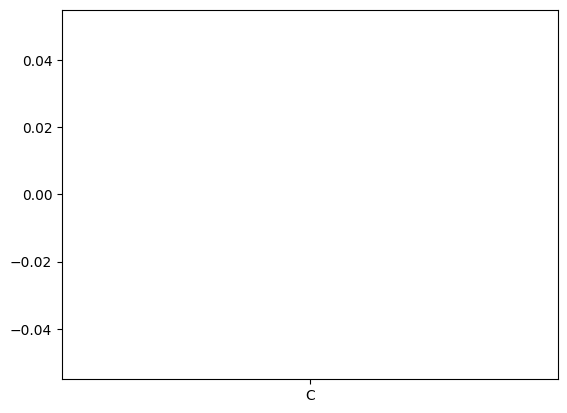

### Seperate Utilities

In [ ]:
# D = Non 2 to 4 apartments
# B = Part Separate
# A = Central (heater, hot water tank, electrical, gas)
# C = All seperate (except water)

In [ ]:
data.parcel_shape.value_counts(dropna=False)